## Part 1 -- 取出大盤資料

/Users/irenetsai/opt/anaconda3/envs/finlab/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


<AxesSubplot:xlabel='date'>

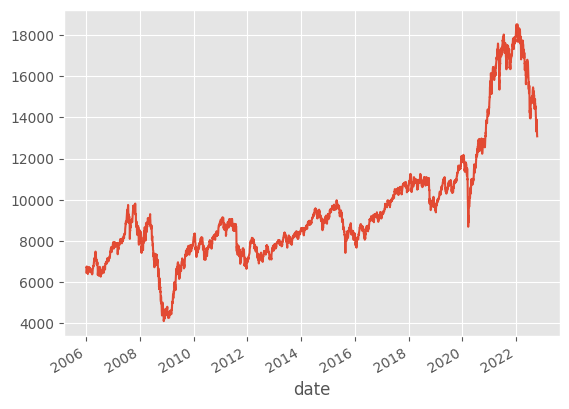

In [2]:
## import dataset 
from finlab.data import Data
data = Data()
twii = data.get('發行量加權股價指數')
twii = twii[(twii.index.hour == 13) & (twii.index.minute == 30)]['台股指數']

## draw twii
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
twii.plot()

## Part 2 -- 回測乖離率績效

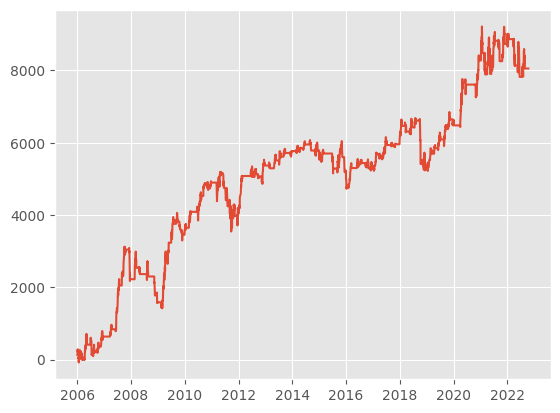

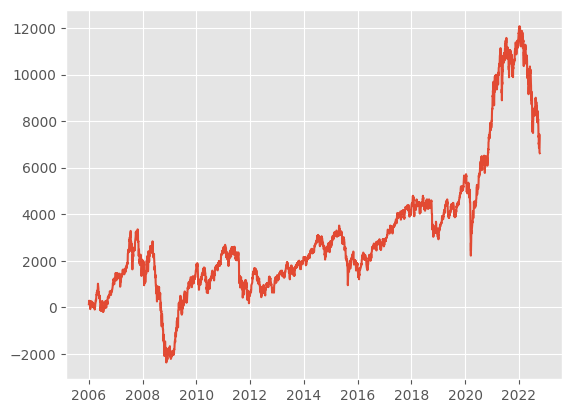

In [3]:
import pandas as pd
import numpy as np

## 畫出乖離率
sma = twii.rolling(20).mean()
bias = twii/sma 

ub = bias.rolling(20).mean() + bias.rolling(5).std()*3
lb = bias.rolling(20).mean() - bias.rolling(5).std()*2

## 如果乖離率過大，則買入；乖離率過小，則賣出（追漲殺跌）
buy = bias > ub
sell = bias < lb
hold = pd.Series(np.nan, index=twii.index)
hold[buy] = 1
hold[sell] = 0
hold = hold.ffill()

## 計算報酬
ret = twii.shift(-1) - twii
ret[hold==0] = 0 
cret = ret.cumsum()

plt.plot(cret)
plt.show()

## 跟大盤比
ret2 = twii.shift(-1) - twii
cret_twii = ret2.cumsum()
plt.plot(cret_twii)

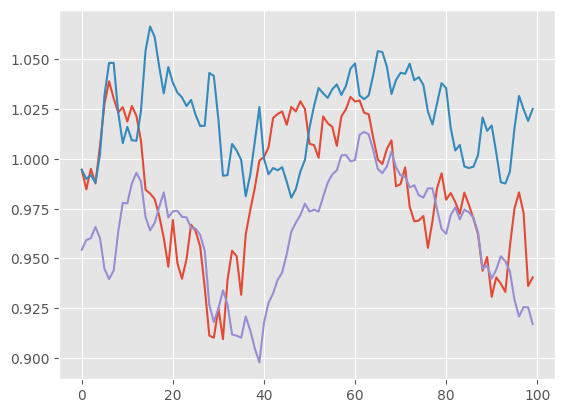

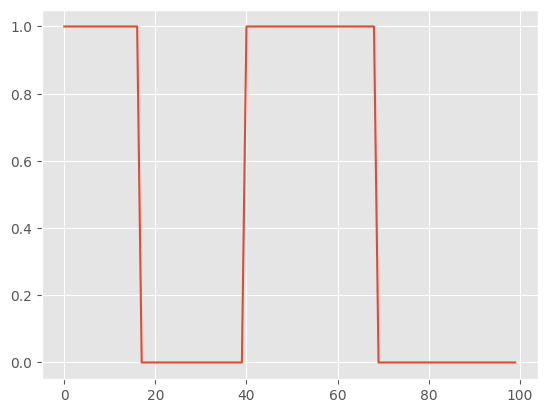

In [4]:
## 畫出乖離率與上下界
plt.plot(bias[-100:].values)
plt.plot(ub[-100:].values)
plt.plot(lb[-100:].values)
plt.show()

plt.plot(hold[-100:].values)

## Part 2 延伸：將回測過程寫成函數

In [5]:
## 寫成函數
import pandas as pd
import numpy as np

def bias_strategy(m1,m2,m3,m4,m5,plot): 
    ## 畫出乖離率
    sma = twii.rolling(m1).mean()
    bias = twii/sma 
    
    ub = bias.rolling(m2).mean() + bias.rolling(m3).std()*m4
    lb = bias.rolling(m2).mean() - bias.rolling(m3).std()*m5
    
    ## 如果乖離率過大，則買入；乖離率過小，則賣出（追漲殺跌）
    buy = bias > ub
    sell = bias < lb
    hold = pd.Series(np.nan, index=twii.index)
    hold[buy] = 1
    hold[sell] = 0
    hold = hold.ffill()
    #hold = hold.shift() ## 當訊號出現，下一天才執行
    
    ## 計算報酬
    ret = twii.shift(-1) - twii
    ret[hold==0] = 0 
    ret -= hold.diff().abs()*3 ## 手續費與滑價
    cret = ret.cumsum()

    ## 跟大盤比
    ret = twii.shift(-1) - twii
    cret_twii = ret.cumsum()
    
    if plot==True: 
        plt.plot(cret)
        plt.show()
        plt.plot(cret_twii)
    
    return cret.iloc[-1].round(2)

    #print('這個策略賺了', str(cret.dropna().iloc[-1].round(2)))
    #print('大盤賺了', str(cret_twii.dropna().iloc[-1].round(2)))

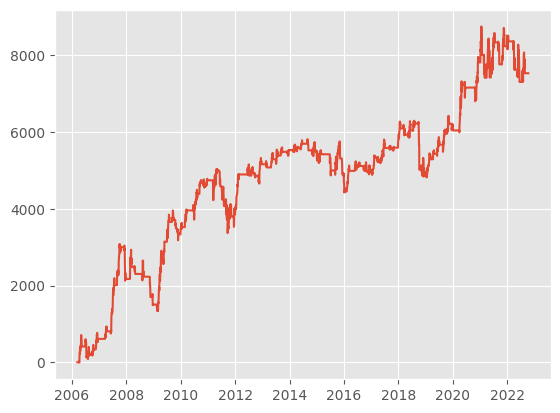

7535.11

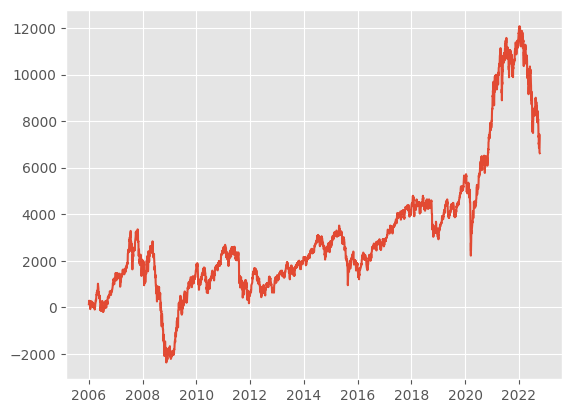

In [6]:
bias_strategy(20, 20, 5, 3, 2, True)

## Part 3：調整參數，尋找最佳報酬

In [10]:
## 乖離率策略優化
ret_max = 0
for m1 in range(2, 60, 1):
    for m2 in range(2, 30, 1): 
        for m3 in range(1, 30, 1):
            cret = bias_strategy(m1,m2,m3,2,1.5,plot=False)
            if cret > ret_max:
                print(m1, m2, m3, cret)
                ret_max = cret

2 2 11 31.73
2 2 12 263.93
2 2 14 485.77
2 2 15 1070.73
2 2 16 4475.92
2 2 18 4890.24
2 2 19 6583.03
2 2 29 6689.6
2 3 16 7861.79
2 3 17 8686.56
2 3 19 9109.62
2 3 20 9180.03
2 3 22 9610.71
2 3 23 9760.72
2 3 29 10468.26
3 5 2 12236.5


## Part 4：評估模型

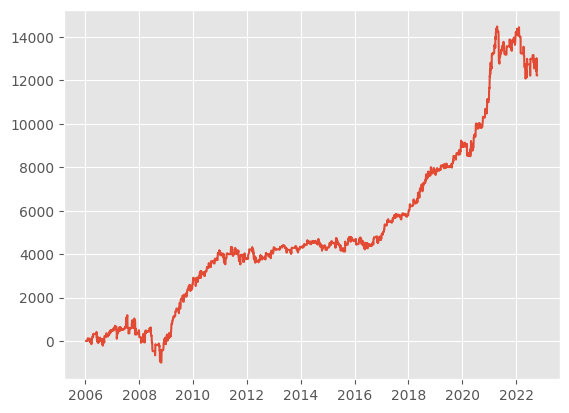

12236.5

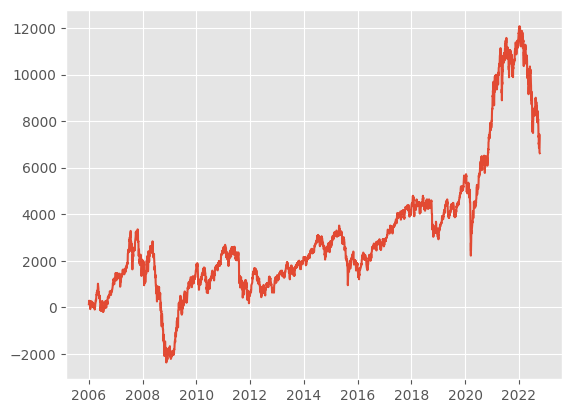

In [11]:
## 繪製出調整參數後的模型報酬-(1)
bias_strategy(3, 5, 2, 2, 1.5, plot=True)

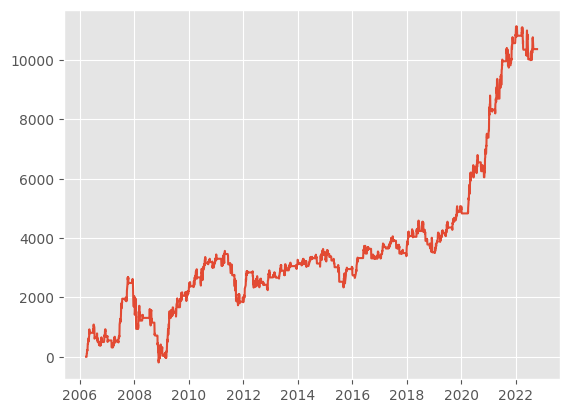

10370.68

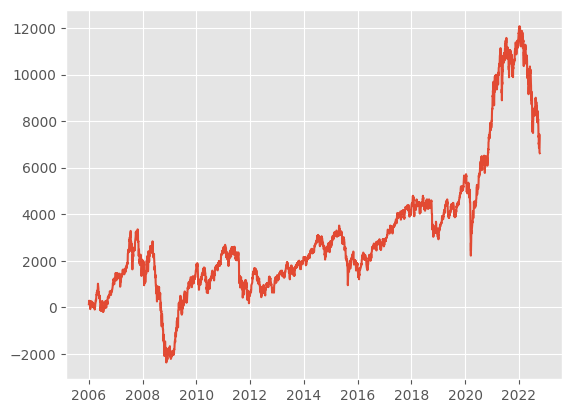

In [9]:
## 繪製出調整參數後的模型報酬-(2)
bias_strategy(25, 27, 2, 3, 2, plot=True)